In [57]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [58]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

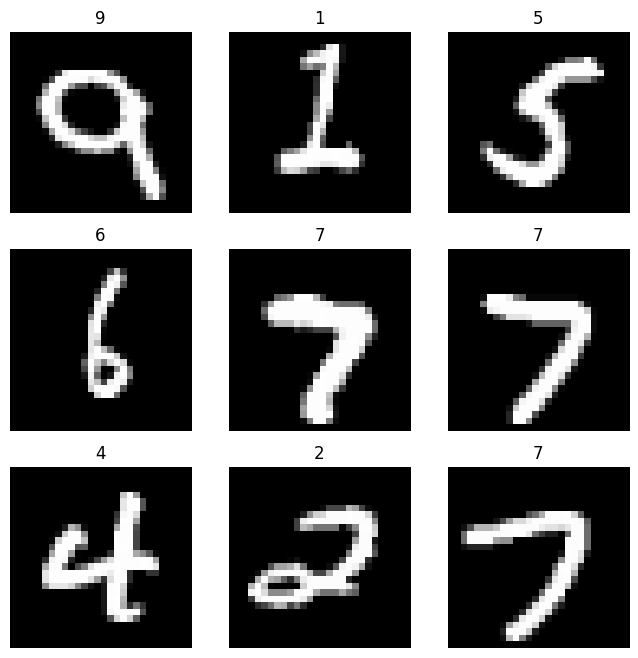

In [59]:
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [60]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [61]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [63]:
def train(train_loader, model, criterion, optimizer, num_epochs=5):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            _, predicted = torch.max(y_pred, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return train_losses, train_accuracies


In [64]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
epochs = 10
all_train_losses = []
all_train_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_losses, train_accuracies = train(train_dataloader, model, loss_fn, optimizer, num_epochs=1)
    test(test_dataloader, model, loss_fn)
    
    all_train_losses.extend(train_losses)
    all_train_accuracies.extend(train_accuracies)

print("Done!")


Epoch 1
-------------------------------
Epoch 1/1, Loss: 2.2800, Accuracy: 0.3126
Test Error: 
 Accuracy: 44.3%, Avg loss: 2.254377 

Epoch 2
-------------------------------
Epoch 1/1, Loss: 2.2240, Accuracy: 0.4813
Test Error: 
 Accuracy: 53.1%, Avg loss: 2.184399 

Epoch 3
-------------------------------
Epoch 1/1, Loss: 2.1333, Accuracy: 0.5633
Test Error: 
 Accuracy: 60.9%, Avg loss: 2.064490 

Epoch 4
-------------------------------
Epoch 1/1, Loss: 1.9785, Accuracy: 0.6429
Test Error: 
 Accuracy: 68.4%, Avg loss: 1.863959 

Epoch 5
-------------------------------
Epoch 1/1, Loss: 1.7363, Accuracy: 0.7028
Test Error: 
 Accuracy: 73.4%, Avg loss: 1.572787 

Epoch 6
-------------------------------
Epoch 1/1, Loss: 1.4276, Accuracy: 0.7449
Test Error: 
 Accuracy: 77.7%, Avg loss: 1.252863 

Epoch 7
-------------------------------
Epoch 1/1, Loss: 1.1396, Accuracy: 0.7788
Test Error: 
 Accuracy: 79.9%, Avg loss: 1.001156 

Epoch 8
-------------------------------
Epoch 1/1, Loss: 0.931

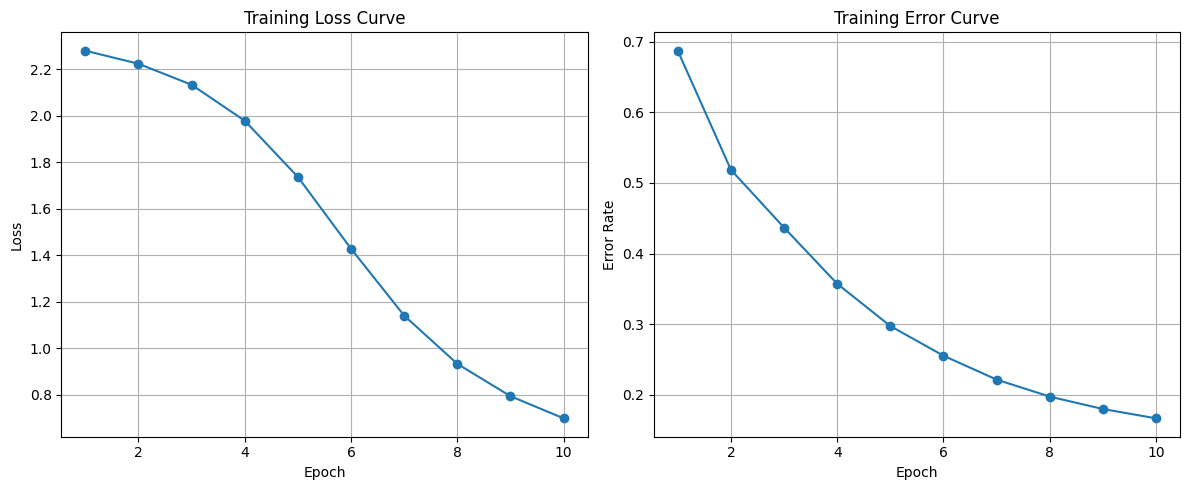

In [66]:
# Plotting Loss and Error curves
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Training Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs_range, all_train_losses, marker='o', label='Training Loss')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Training Error Curve (1 - accuracy)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, [1 - acc for acc in all_train_accuracies], marker='o', label='Training Error')
plt.title("Training Error Curve")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.grid(True)

plt.tight_layout()
plt.show()


In [67]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [68]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [69]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"
